### This notebook is to plot how the node strength of the fussioned matrices changes across brain areas for the different gamma fusion parameters. 

Run the cells of this notebook after running the cells of the notebook `01-fussioned-matrices.ipynb`.

In [1]:
import numpy as np
import nibabel as nib
from nilearn import plotting
from src.connectivity_functions import *
from src.tree_functions import *
from src.ni_functions import *
from src.io_functions import load_data
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

First, it's needed to define the connectome size, it's possible to choose between the following number of nodes: 183, 391, 568, 729, 964, 1242, 1584, 1795, 2165

In [2]:
project_path = "/workspaces/bha2"
conn_size = 2165

The node strengths are calculated on the population average SC and FC matrices. In order to not reload the individual matrices or recalculate the population average, the code checks if the population average matrices are already in the bha2/tmp folder. If they are not, the code will load the individual matrices and calculate the population average matrices.

In [3]:
if os.path.exists(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")):
    fcm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"))
    scm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"))
    print("fcm and scm loaded from tmp folder")
else:
    sc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(conn_size), "sc")
    )
    fc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(conn_size), "fc")
    )
    fcm, scm = connectome_average(fc_group, sc_group)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"), fcm)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"), scm)

fcm and scm loaded from tmp folder


Preprocessing of the SC and FC population matrices is needed before building the dendrogram trees. The preprocessing includes the following steps:
* Remove ROIs disconnected in the SC matrix
* Calculate the density of the SC matrix and apply a threshold to the FC matrix to keep the same density in both matrices
* Remove ROIs disconnected in the thresholded SC matrix
* Binarize both matrices

In [4]:
zero_rows_sc = np.where(~scm.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (
    len(scm_nonzero.flatten())
)
fcm_thr = density_threshold(fcm_nonzero, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(
    zero_rows_fc, fcm_thr, scm_nonzero
)
fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0)

print("connectome density = " + str(density))

connectome density = 0.07191603968863612


Loading the parcellation without the disconnected ROIs

In [5]:
initial_parcellation = nib.load(os.path.join(
        project_path,
        "data",
        "processed",
        "n" + str(conn_size),
        "initial_partition.nii.gz",
    ))
initial_parcellation_data = initial_parcellation.get_fdata()

Plotting in the brain the node strength of each ROI for all the fusioned $\gamma$ matrices. The strength is normalized by the maximum strength of the matrix. The figure is saved in bha2/data/figures and each strength brain map is saved in bha2/data/processed/conn_size

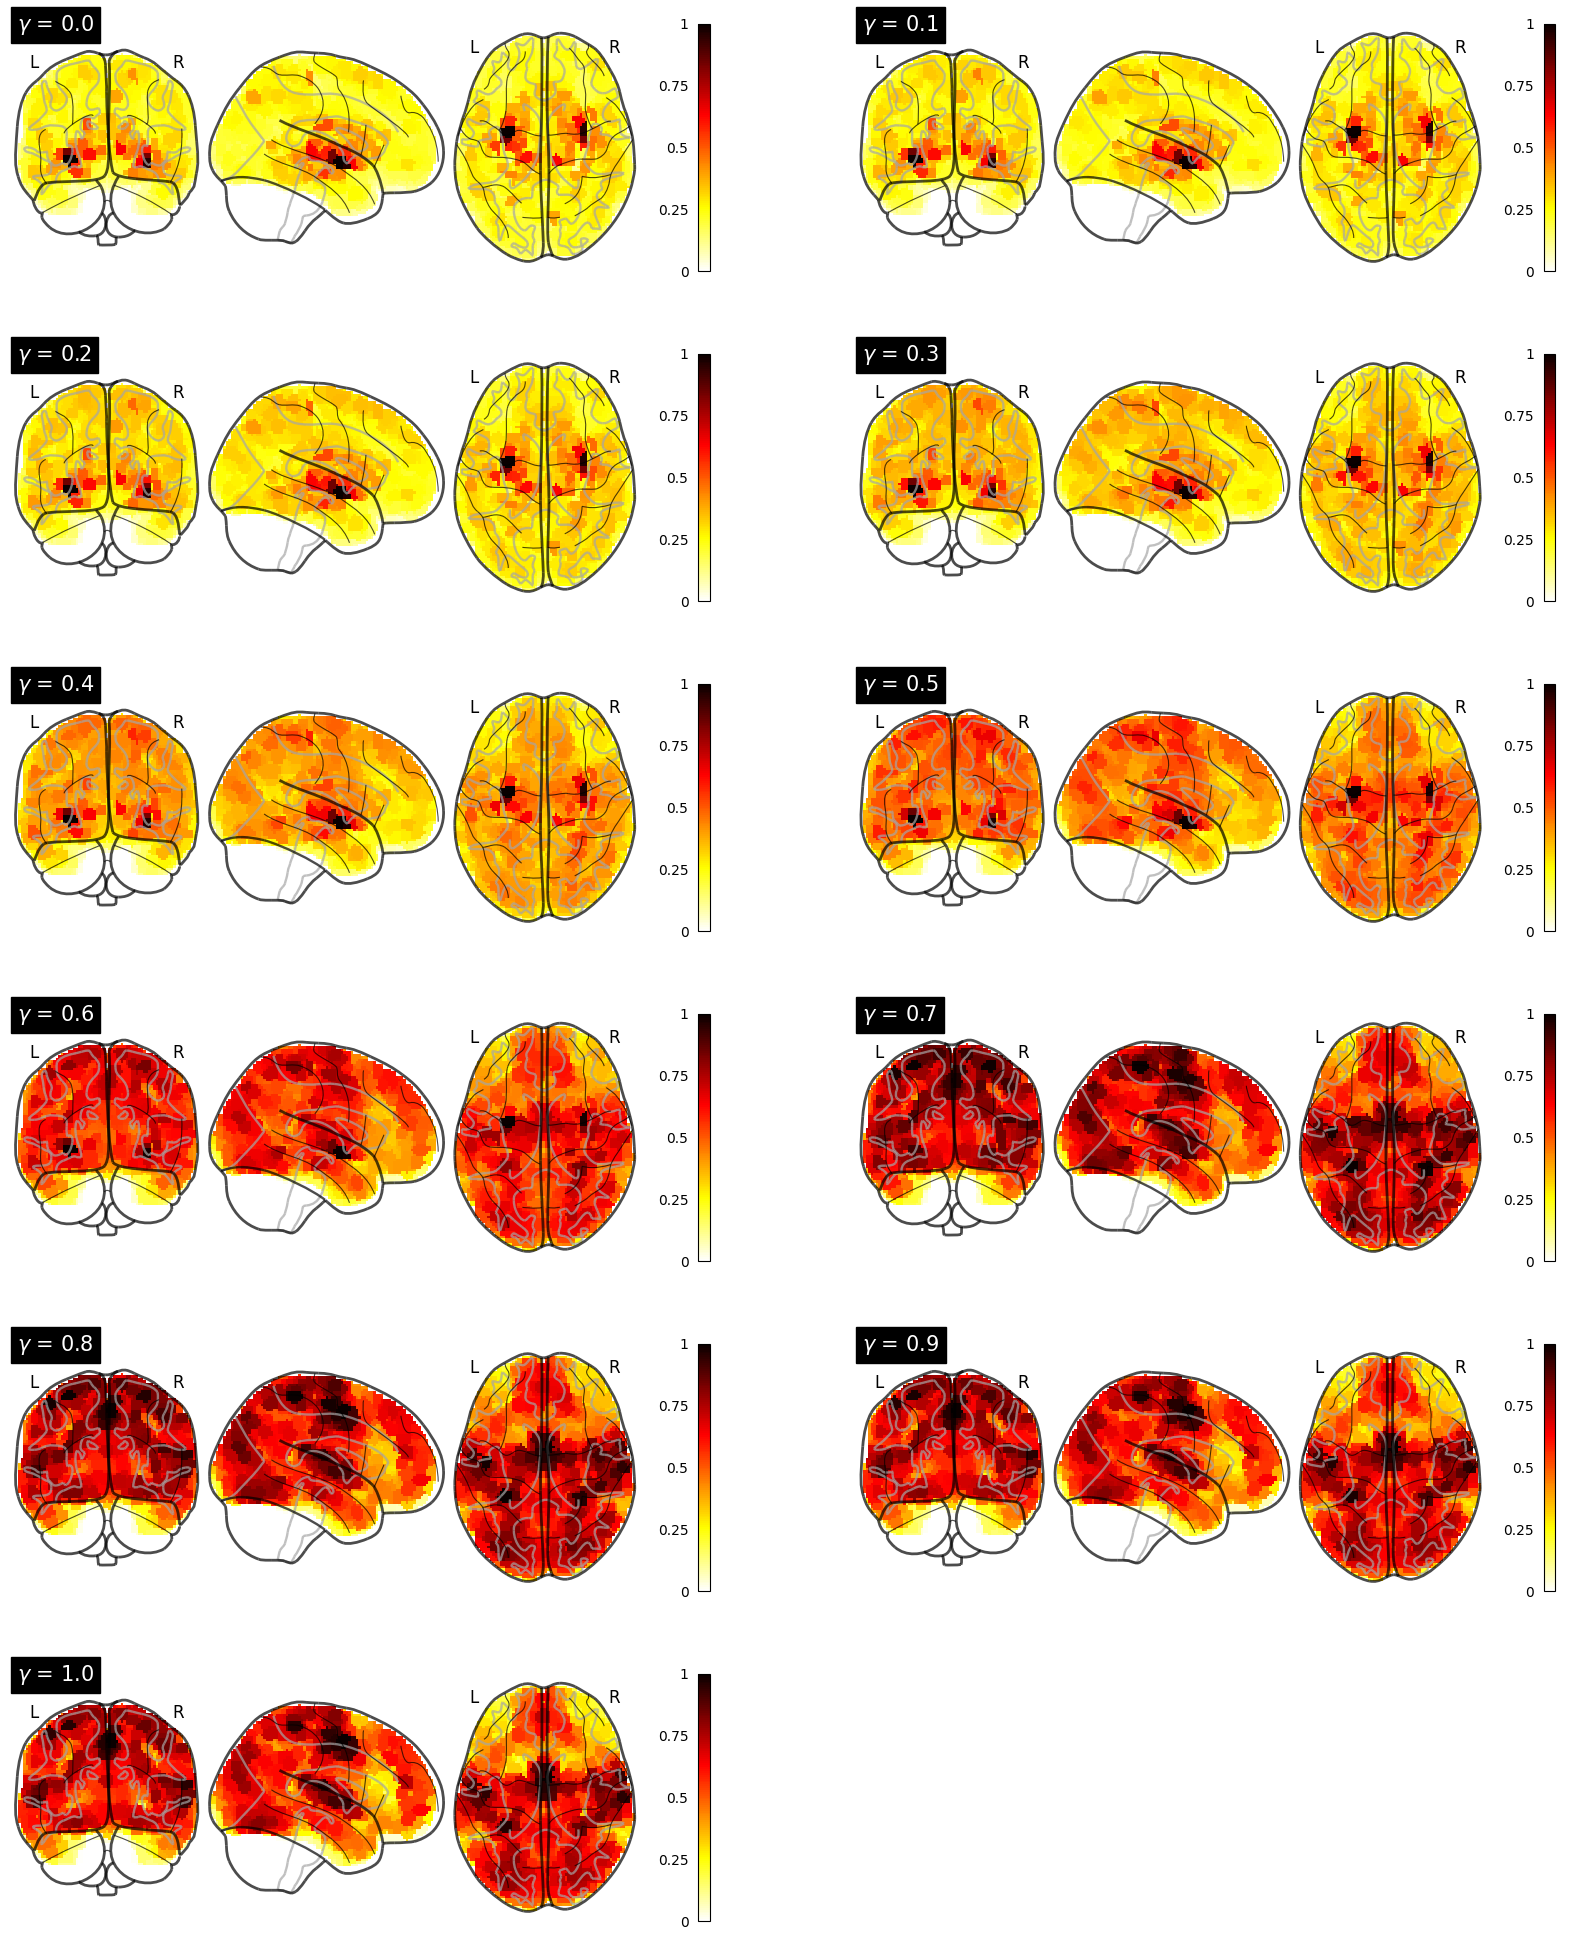

In [6]:
fig = plt.figure(figsize=(20, 25))

gammas_vec = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for idx, g in enumerate(gammas_vec):
    ax = fig.add_subplot(6, 2, idx + 1)
    gfusion_mat = matrix_fusion(g, fcm_bin, scm_bin)
    strength_fullmat = gfusion_mat.sum(axis=0, dtype=float)
    deg_img = np.zeros(initial_parcellation_data.shape)
    for roi in range(len(strength_fullmat)):
        deg_img[initial_parcellation_data == roi + 1] = strength_fullmat[roi] / np.max(strength_fullmat)
    plotting.plot_glass_brain(
        nib.Nifti1Image(deg_img, affine=initial_parcellation.affine),
        colorbar=True,
        title= r"$\gamma$" + " = " + str(g),
        axes=ax,
    )
    plt.savefig(
        os.path.join(project_path, "data", "figures", "gamma_degrees_brain.svg"),
        dpi=300,
        bbox_inches="tight",
        format="svg",
    )
    nib.save(
        nib.Nifti1Image(deg_img, affine=initial_parcellation.affine),
        os.path.join(
            project_path,
            "data",
            "processed",
            "n" + str(conn_size),
            "strength_g_" + str(g) + ".nii.gz",
        ),
    )

Plotting for each macro-region the sum of the node strengths of the ROIs incude in them for all the fusioned $\gamma$ matrices. The strength is normalized by the maximum strength inside each macror-region. The figure is saved in bha2/data/figures.

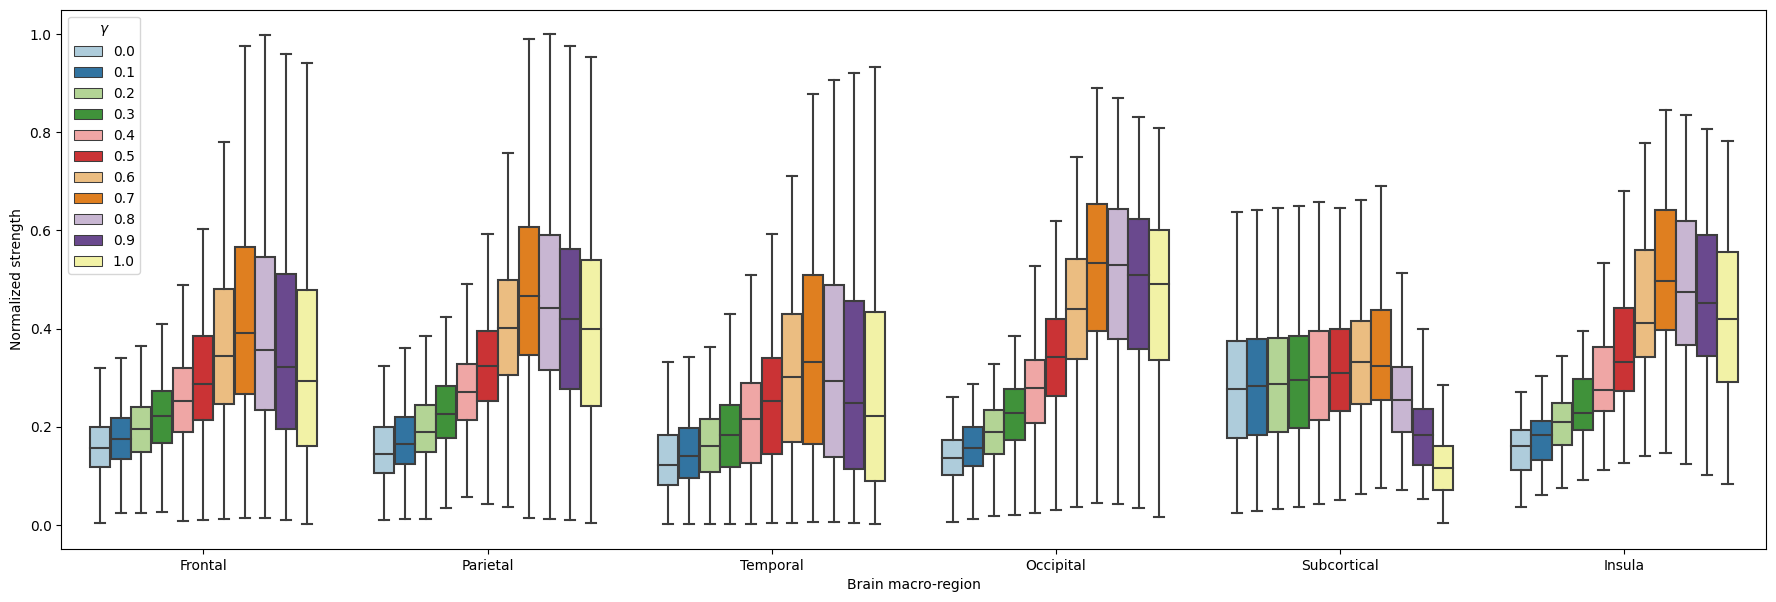

In [16]:
gammas_vec = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
lobe_list = ["Frontal", "Parietal", "Temporal", "Occipital", "Subcortical", "Insula"]

strength_vals = []
area_name = []
gamma_val = []
for lobe in lobe_list:
    lobe_mask = nib.load(
        os.path.join(
            project_path, "brain_templates", "lobule_masks", lobe + "_mask.nii.gz"
        )
    )
    lobe_rois = get_atlas_rois_from_mask(lobe_mask, initial_parcellation)
    for g in gammas_vec:
        gfusion_mat = matrix_fusion(g, fcm_bin, scm_bin)
        strength_fullmat = gfusion_mat.sum(axis=0, dtype=float)
        for roi in lobe_rois:
            strength_vals.append(
                strength_fullmat[int(roi) - 1] / np.max(strength_fullmat)
            )
            area_name.append(lobe)
            gamma_val.append(g)

fig = plt.figure(figsize=(22,7))
df = pd.DataFrame({"Normalized strength": strength_vals, "Brain macro-region": area_name, "gamma": gamma_val})
sns.boxplot(x="Brain macro-region", y="Normalized strength", hue="gamma", data=df, showfliers=False, palette="Paired")
plt.legend(loc="upper left", title=r"$\gamma$")
plt.savefig(
        os.path.join(project_path, "data", "figures", "gamma_Normalized strengths_lobules.svg"),
        dpi=300,
        bbox_inches="tight",
        format="svg",
    )